In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.metrics import recall_score,f1_score,roc_auc_score,accuracy_score,confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit


In [3]:
train_data = pd.read_csv('../../../data/feature/user_feature_train_2.csv')
#test_data = pd.read_csv('../../data/test_data1.csv')
train_data.head()

,user_id,merchant_id,user_viewed_action_count,user_viewed_item_cat_num,user_viewed_item_brand_num,user_viewed_item_num,user_viewed_item_click,user_viewed_item_addcart,user_viewed_item_buy,user_viewed_item_addcat,...,user_click_ratio,user_buy_ratio,user_addcat_ratio,user_buy_ratio2,repeat_viewed_count,repeat_buyer_same_item_count,repeat_buyer_diff_item_count,age_range,gender,label
0,34176,3906,39,6,1,20,36,0,1,2,...,0.923077,0.025641,0.051282,0.333333,2,0,1,6.0,0.0,0
1,34176,121,14,1,1,1,13,0,1,0,...,0.928571,0.071429,0.000000,1.000000,1,0,1,6.0,0.0,0
2,34176,4356,18,1,1,2,12,0,6,0,...,0.666667,0.333333,0.000000,1.000000,1,1,2,6.0,0.0,1
3,34176,2217,2,1,1,1,1,0,1,0,...,0.500000,0.500000,0.000000,1.000000,0,0,1,6.0,0.0,0
4,230784,4818,8,1,1,1,7,0,1,0,...,0.875000,0.125000,0.000000,1.000000,1,0,1,0.0,0.0,0


In [37]:
y = train_data['label'].values
X = train_data.drop(['label', 'user_id', 'merchant_id'], axis=1).values
X.shape

(260864, 18)

#### 切下数据,交叉验证一下,然后简单跑一次看看

In [38]:
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=2018)
for train_index ,test_index in ss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [133396  70415 205049 ..., 240081 238195 240749] TEST: [109297 175700 133527 ..., 118224 196859   9818]


In [39]:
#样本权重
def get_scale_pos_weight(y_train):
    label = y_train.value_counts()
    ratio = float(label[0]) / float(label[1])
    return ratio
class_weight = get_scale_pos_weight(train_data['label'])

In [40]:
xgb = XGBClassifier(n_estimators=100,\
                       max_depth=3, \
                       learning_rate=0.1, \
                       subsample=0.8, \
                       colsample_bytree=0.8, \
                       scale_pos_weight=class_weight,
                       n_jobs=-1,
                       random_state=2018)

xgb.fit(X_train, y_train)

preds = xgb.predict(X_test)

# 判断准确率
print ('错误类为%f' %((preds!=y_test).sum()/float(y_test.shape[0])))
print("recall_score : %.3f" % recall_score(preds, y_test))
print("f1_score : %.3f" %  f1_score(preds, y_test))
print("auc : %.3f" % roc_auc_score(preds, y_test))
print("accuracy_score : %.3f " % accuracy_score(preds, y_test))
print ("混淆矩阵：",confusion_matrix(y_test, preds))

错误类为0.325288
recall_score : 0.094
f1_score : 0.158
auc : 0.524
accuracy_score : 0.675 
混淆矩阵： [[50413 23061]
 [ 2396  2390]]


In [88]:
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [15]:
print(train_data.drop(['label', 'user_id', 'merchant_id', 'age_range', 'gender'], axis=1).columns)
print(xgb.feature_importances_)

Index(['user_viewed_action_count', 'user_viewed_item_cat_num',
       'user_viewed_item_brand_num', 'user_viewed_item_num',
       'user_viewed_item_click', 'user_viewed_item_addcart',
       'user_viewed_item_buy', 'user_viewed_item_addcat', 'user_addcart_ratio',
       'user_click_ratio', 'user_buy_ratio', 'user_addcat_ratio',
       'user_buy_ratio2', 'repeat_viewed_count',
       'repeat_buyer_same_item_count', 'repeat_buyer_diff_item_count'],
      dtype='object')
[ 0.12503709  0.09615194  0.04946088  0.11633198  0.06845386  0.00593531
  0.03224849  0.02552181  0.02621426  0.14828371  0.08507271  0.07082798
  0.02532397  0.09120586  0.01276091  0.02116925]


* user_viewed_item_cat_num
* user_viewed_item_num
* user_viewed_item_buy  

这几个特征重要度高

In [21]:
cv_rf = XGBClassifier(n_jobs=-1, scale_pos_weight=class_weight, random_state=2018)
param_grid = {'learning_rate': [0.1, 0.3, 0.8], 'max_depth': [3, 6, 9], 'n_estimators': [100, 150, 200]}
grid_search = GridSearchCV(cv_rf, param_grid, cv=ss, scoring='roc_auc')
grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)


0.62386344687844009

In [24]:
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.618554976517
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=2018, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=15.353059177532598, seed=None, silent=True,
       subsample=1)


In [23]:
grid_search.grid_scores_

C:\Users\zzf\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.61855, std: 0.00000, params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100},
 mean: 0.61821, std: 0.00000, params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150},
 mean: 0.61759, std: 0.00000, params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200},
 mean: 0.60157, std: 0.00000, params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100},
 mean: 0.59083, std: 0.00000, params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 150},
 mean: 0.58436, std: 0.00000, params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200},
 mean: 0.56797, std: 0.00000, params: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100},
 mean: 0.55611, std: 0.00000, params: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 150},
 mean: 0.54262, std: 0.00000, params: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200},
 mean: 0.61269, std: 0.00000, params: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100},
 mean: 0.6

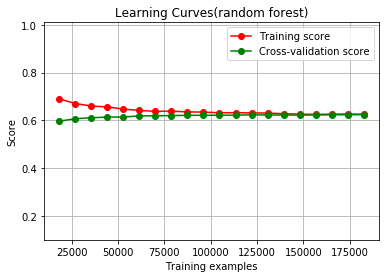

In [28]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 20), scoring='roc_auc'):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = 'Learning Curves(random forest)'
plot_learning_curve(xgb, title, X, y, (0.1, 1.01), cv=ss, n_jobs=4)
plt.show()

In [29]:
#测试数据
test_data = pd.read_csv('../../../data/feature/user_feature_test_2.csv')
test_data.head()

,user_id,merchant_id,user_viewed_action_count,user_viewed_item_cat_num,user_viewed_item_brand_num,user_viewed_item_num,user_viewed_item_click,user_viewed_item_addcart,user_viewed_item_buy,user_viewed_item_addcat,user_addcart_ratio,user_click_ratio,user_buy_ratio,user_addcat_ratio,user_buy_ratio2,repeat_viewed_count,repeat_buyer_same_item_count,repeat_buyer_diff_item_count,age_range,gender
0,163968,4605,2,1,1,1,1,0,1,0,0.0,0.500000,0.500000,0.00,1.000000,0,0,1,0.0,0.0
1,360576,1581,10,4,1,9,5,0,5,0,0.0,0.500000,0.500000,0.00,1.000000,0,0,5,2.0,2.0
2,98688,1964,6,1,1,1,5,0,1,0,0.0,0.833333,0.166667,0.00,1.000000,0,0,1,6.0,0.0
3,98688,3645,11,1,1,1,10,0,1,0,0.0,0.909091,0.090909,0.00,1.000000,0,0,1,6.0,0.0
4,295296,3361,50,4,2,8,47,0,1,2,0.0,0.940000,0.020000,0.04,0.333333,4,0,1,2.0,1.0


In [55]:
user_seller = test_data[["user_id", "merchant_id"]]
predict_data = test_data.drop(["user_id", "merchant_id"], axis=1)
user_seller.head()

,user_id,merchant_id
0,163968,4605
1,360576,1581
2,98688,1964
3,98688,3645
4,295296,3361


In [59]:
predict_data.values

array([[  0.00000000e+00,   2.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   1.00000000e+01,   4.00000000e+00, ...,
          5.00000000e+00,   2.00000000e+00,   2.00000000e+00],
       [  2.00000000e+00,   6.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   6.00000000e+00,   0.00000000e+00],
       ..., 
       [  2.61474000e+05,   1.60000000e+01,   2.00000000e+00, ...,
          3.00000000e+00,   8.00000000e+00,   1.00000000e+00],
       [  2.61475000e+05,   3.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.61476000e+05,   1.10000000e+01,   1.00000000e+00, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [60]:
#用全量数据训练
y = train_data['label'].values
X = train_data.drop(['label', 'user_id', 'merchant_id'], axis=1).values

xgb = XGBClassifier(n_estimators=100,\
                       max_depth=3, \
                       learning_rate=0.1, \
                       subsample=0.8, \
                       colsample_bytree=0.8, \
                       scale_pos_weight=class_weight,
                       n_jobs=-1,
                       random_state=2018)

xgb.fit(X, y)

preds = xgb.predict_proba(predict_data.values)
preds.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [64]:
user_seller['prob'] = preds[:,1]

C:\Users\zzf\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [67]:
user_seller.to_csv('../../../data/result/result1.csv', index=False)